# Excited Second Bending Mode

This example shows how to simulate a simply supported beam with an excited second bending
mode

![](../assets/excited-simulation.gif)

In [1]:
using GXBeam, LinearAlgebra

# simply-supported beam with excited second bending mode

# beam properties
L = 1
EA = 1
EI = 1
ρA = 1

# generate points
nelem = 40
x = range(0, L, length=nelem+1)
y = zero(x)
z = zero(x)
points = [[x[i],y[i],z[i]] for i = 1:length(x)]

# define connectivity
start = 1:nelem
stop = 2:nelem+1

# compliance matrix for each beam element
compliance = fill(Diagonal([1e-6, 1e-6, 1e-6, 1e-6, 1/EI, 1e-6]), nelem)

# mass matrix for each beam element
mass = fill(Diagonal([ρA, ρA, ρA, 1e-6, 1e-6, 1e-6]), nelem)

# create assembly
assembly = Assembly(points, start, stop; compliance=compliance, mass=mass)

# excite the second bending mode
delta = 1e-3 ## displacement magnitude
uz = delta*sin.(2*pi*x/L) ## linear displacement
u0 = [[0, 0, uz[i]] for i in eachindex(uz)]

# prescribe the vertical displacement of each point
prescribed_conditions = Dict(i => PrescribedConditions(uz = uz[i]) for i = 1:length(points))

# simply supported left side
prescribed_conditions[1] = PrescribedConditions(ux=0, uy=0, uz=0)

# simply supported right side
prescribed_conditions[nelem+1] = PrescribedConditions(uz=0)

# solve for static operating conditions
system, state, converged = static_analysis(assembly; prescribed_conditions)

# extract initial conditions from the state vector
u0 = getproperty.(state.points, :u)
theta0 = getproperty.(state.points, :theta)

# set new prescribed conditions
prescribed_conditions = Dict(
    # simply supported left side
    1 => PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_z=0),
    # simply supported right side
    nelem+1 => PrescribedConditions(uz=0)
)

# excited mode natural frequency
ω = (2*pi/L)^2*sqrt((EI)/(ρA))

# solution time vector
t = range(0, 2*pi/ω, step=0.001)

# perform time domain analysis
system, history, converged = time_domain_analysis(assembly, t;
    prescribed_conditions = prescribed_conditions,
    structural_damping = false,
    u0=u0, theta0=theta0)

# write visualization file
mkpath("excited-simulation")
write_vtk("excited-simulation/excited-simulation", assembly, history, t; scaling = 100)

![](../assets/excited-simulation.gif)

Plotting the results reveals that the analytical and computational solutions show
excellent agreement.

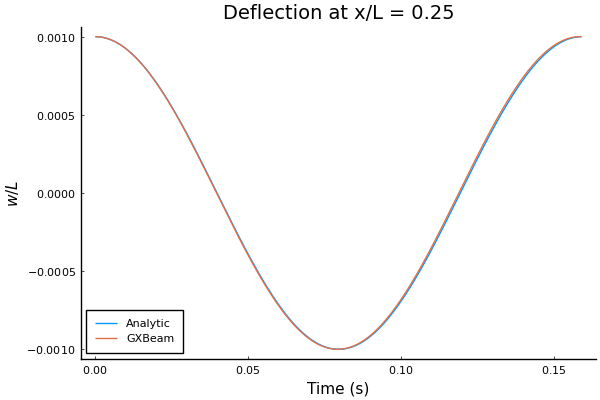

In [2]:
# Get displacements at 1/4 of the beam's length
ipoint = div(nelem, 4) + 1

# calculated deflection
w14_gxbeam = [state.points[ipoint].u[3]/L for state in history]

# analytic deflection
w14_analytic = delta/L*cos.(ω*t)*sin(2*pi*x[ipoint]/L)

# Plot
using Plots
pyplot()
plot(
    title="Deflection at x/L = $(x[ipoint]/L)",
    xlabel = "Time (s)",
    ylabel = "\$w/L\$",
    grid = false,
    legend = :bottomleft,
    overwrite_figure=false
    )
plot!(t, w14_analytic, label="Analytic")
plot!(t, w14_gxbeam, label="GXBeam")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*